# Variational optimization of continuous matrix product states

In the following notebook, we illustrate how the results of [arXiv:2006.01801](https://arxiv.org/abs/2006.01801) can be obtained by using the package [CMPSKit.jl](https://github.com/Jutho/CMPSKit.jl). This package is not yet registered as an official Julia package. It also depends on the two registered packages [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl) and [OptimKit.jl](https://github.com/Jutho/OptimKit.jl), which would be installed automatically, but which we want to have explicitly available to change the default parameters. For plotting, we will use [Plots.jl](https://github.com/JuliaPlots/Plots.jl), while [JLD2.jl](https://github.com/JuliaIO/JLD2.jl) will be used to load precomputed data. These packages can be installed by uncommenting the following commands:

In [1]:
#import Pkg;
#Pkg.add("KrylovKit","OptimKit","Plots","JLD2")
#Pkg.add(url="https://github.com/Jutho/CMPSKit.jl")

Now, we load 

In [2]:
using Revise
using CMPSKit
using KrylovKit: Arnoldi, GMRES
using OptimKit: GradientDescent, ConjugateGradient, LBFGS
using JLD2
using Plots
using IJulia

### Tonks-Girardeau limit and free fermions

We first consider interacting bosonic particles in a box $[a,b]$, i.e. without an external potential and only a contact interaction term.

In [3]:
# The Hamiltonian (Lieb-Liniger):
a = 0
b = 1
g = 1e6;

n̂ = ψ'*ψ; # particle density operator
k̂ = ∂ψ'*∂ψ; # kinetic energy density operator
û = (ψ')^2*ψ^2; # interaction operator

N̂ = ∫(n̂, (a,b)); # total particle number
Ĥ = ∫(k̂ + g * û, (a, b));

In the limit of large interaction strength $g$, we are in the Tonks-Girardeau limit, where the interacting bosonic system behaves as a free fermion system. For particles in a box (i.e. zero external potential within the interval), we can construct this Tonks-Girardeau solution starting from the single-particle standing wave solutions. The cMPS representation of the Tonks-Girardeau state has $Q=0$ and $R(x)$ given by

In [4]:
# tonksgirardeau_R(N, x, a = 0, b = 1)(grid, N)
# Computes the cMPS R matrix for the Tonks-Girardeau state with `N` particles in a box in the interval [`a`,`b`]
const σᶻ = [1. 0.; 0. -1.]
const σ⁰ = [1. 0.; 0. 1.]
function tonksgirardeau_R(N, x, a = 0, b = 1)
    L = b-a
    y = (x-a)/L
    R = zeros(Float64, (2^N,2^N))
    for k in 1:N
        Rk = [0. sqrt(2/L)*sin(k*pi*y); 0. 0.]
        for _ in 1:k-1
            Rk = kron(Rk, σᶻ)
        end
        for _ in 1:N-k
            Rk = kron(σ⁰, Rk)
        end
        R .+= Rk
    end
    return R
end

tonksgirardeau_R (generic function with 3 methods)

We will now approximate this continuous matrix function $R(x)$ as a piecewise linear function on a given grid, and wrap the result in a finite cMPS, which also include the matching boundary vectors.

In [5]:
# tonksgirardeau(grid, N)
# Computes and returns a cMPS representation of the Tonks-Girardeau state with `N` particles on a given `grid`;
# the resulting cMPS will have bond dimension 2^N.
function tonksgirardeau(N, grid)
    R = PiecewiseLinear(grid, tonksgirardeau_R.(N, grid, first(grid), last(grid)))
    Q = zero(R)
    vL = zeros(Float64, 2^N); vL[1] = 1;
    vR = zeros(Float64, 2^N); vR[end] = 1;
    return FiniteCMPS(Q, R, vL, vR)
end

tonksgirardeau (generic function with 1 method)

Now that all the infrastructure is set up, let's create such a Tonks-Girardeau state on a certain grid and compute some of its properties.

In [6]:
grid = 0:1/32:1
N = 4
Φ = tonksgirardeau(N, grid);
E = expval(Ĥ, Φ)

298.9066199350958

In [7]:
# compute total particle number, in two ways
expval(N̂, Φ), ∫(expval(n̂, Φ), (a, b))

(3.9999999999999987, 3.9999999999999987)

The expectation value of a local operator is a `Piecewise` object, which can be integrated over, but also can be used as a function.

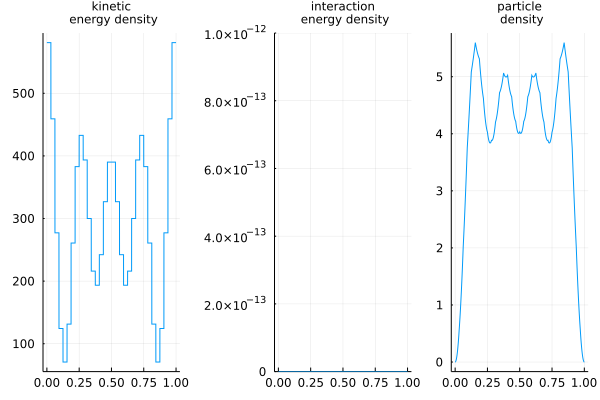

In [8]:
particle_density = expval(n̂, Φ)
kinetic_energy_density = expval(k̂, Φ)
interaction_energy_density = expval(g * û, Φ);# plot densities
plotgrid = 0:1/3200:1;
p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="", title="kinetic\n energy density")
p2 = plot(plotgrid, interaction_energy_density.(plotgrid), label="", ylims=(0.,1e-12), title="interaction\n energy density")
p3 = plot(plotgrid, particle_density.(plotgrid), label="", title="particle\n density")
plot(p1, p2, p3, layout = (1,3), titlefontsize=8)

As we can see, the interaction energy of the Tonks-Girardeau state is zero. All the energy is in the kinetic energy, and it is given by the sum of the `N` lowest single particle energies, which we used to construct the state.

In [9]:
Ekin = ∫(kinetic_energy_density, (a,b));
(E, Ekin)

(298.9066199350958, 298.9066199350958)

In [10]:
Ekin_exact = sum((pi/(b-a)*n)^2 for n=1:N) # sum of single particle energies

296.08813203268073

This discrepancy is due to the coarseness of the grid.

In [11]:
K̂ = ∫(k̂, (a, b))
println(expval(K̂, tonksgirardeau(N, 0:1/32:1)) - Ekin_exact);
println(expval(K̂, tonksgirardeau(N, 0:1/64:1)) - Ekin_exact);
println(expval(K̂, tonksgirardeau(N, 0:1/128:1)) - Ekin_exact);

2.818487902415086
0.7023302737601398
0.17543728732260888


### Variational optimization

To use variational optimization, we need to add a chemical potential, otherwise the lowest energy state is the vacuum with zero energy. We cannot directly target a given particle number in the current cMPS ansatz (unless with a Lagrange parameter, which is exactly the chemical potential).

In [12]:
# The Hamiltonian (Lieb-Liniger):
μ = (4.75*π)^2
Ĥ = Ĥ - μ*N̂;
g = 1e6
Ĥ = ∫(k̂ - μ*n̂ + g*û, (a, b));

In [13]:
D = 8 # bond dimension
T = Float64 # scalar type
grid = 0:1/32:1 # still using the same grid as before
Q₀ = randn(T, (D,D));# Q₀ = (Q₀+Q₀')/2;
R₀ = randn(T, (D,D));# R₀ = (R₀+R₀')/2;
Q = PiecewiseLinear(grid, [Q₀ for x in grid])
R = PiecewiseLinear(grid, [(x == a || x == b) ? zero(R₀) : R₀ for x in grid])
vL = setindex!(zeros(T, D), 1, 1)
vR = setindex!(zeros(T, D), 1, 1)
Φ₀ = FiniteCMPS(Q, R, vL, vR);
E₀ = expval(Ĥ, Φ₀)

1.0401579848423523e8

In [15]:
function plotresults(numiter, E, normgrad, Φ, ρL, ρR, e; plotgrid = 0:1/3200:1)
    IJulia.clear_output(true)
    kinetic_energy_density = expval(k̂, Φ, ρL, ρR)
    interaction_energy_density = expval(g * û, Φ, ρL, ρR);# plot densities
    particle_density = expval(n̂, Φ, ρL, ρR)
    N = ∫(particle_density, (a, b))
    potential_energy_density = -μ*particle_density
    total_energy_density = e;
    p1 = plot(plotgrid, kinetic_energy_density.(plotgrid), label="kinetic")
    plot!(p1, plotgrid, potential_energy_density.(plotgrid), label="potential")
    plot!(p1, plotgrid, interaction_energy_density.(plotgrid), label="interaction")
    plot!(p1, plotgrid, total_energy_density.(plotgrid), label="total")
    plot!(p1, title = "iteration $numiter\n energy densities: E = $E")
    p2 = plot(plotgrid, particle_density.(plotgrid), label="", title="gradient norm = $normgrad \n particle density: N = $N")
    display(plot(p1, p2, layout = (1,2), titlefontsize=8))
end

plotresults (generic function with 1 method)

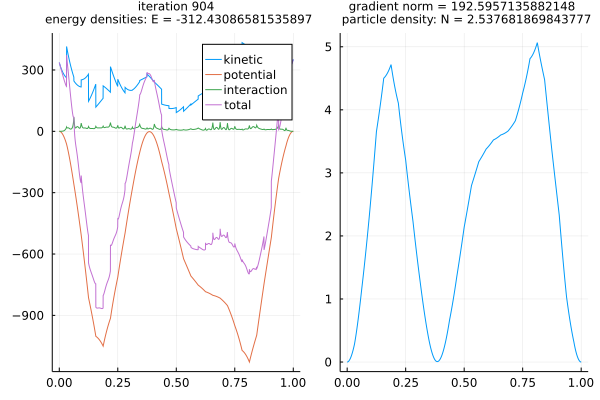

In [ ]:
alg = LBFGS(80; verbosity = 0, maxiter = 1000, gradtol = 1e-3)
Φ, ρL, ρR, E, e, normgrad, numfg, history = groundstate(Ĥ, Φ₀; optalg = alg, callback = plotresults);

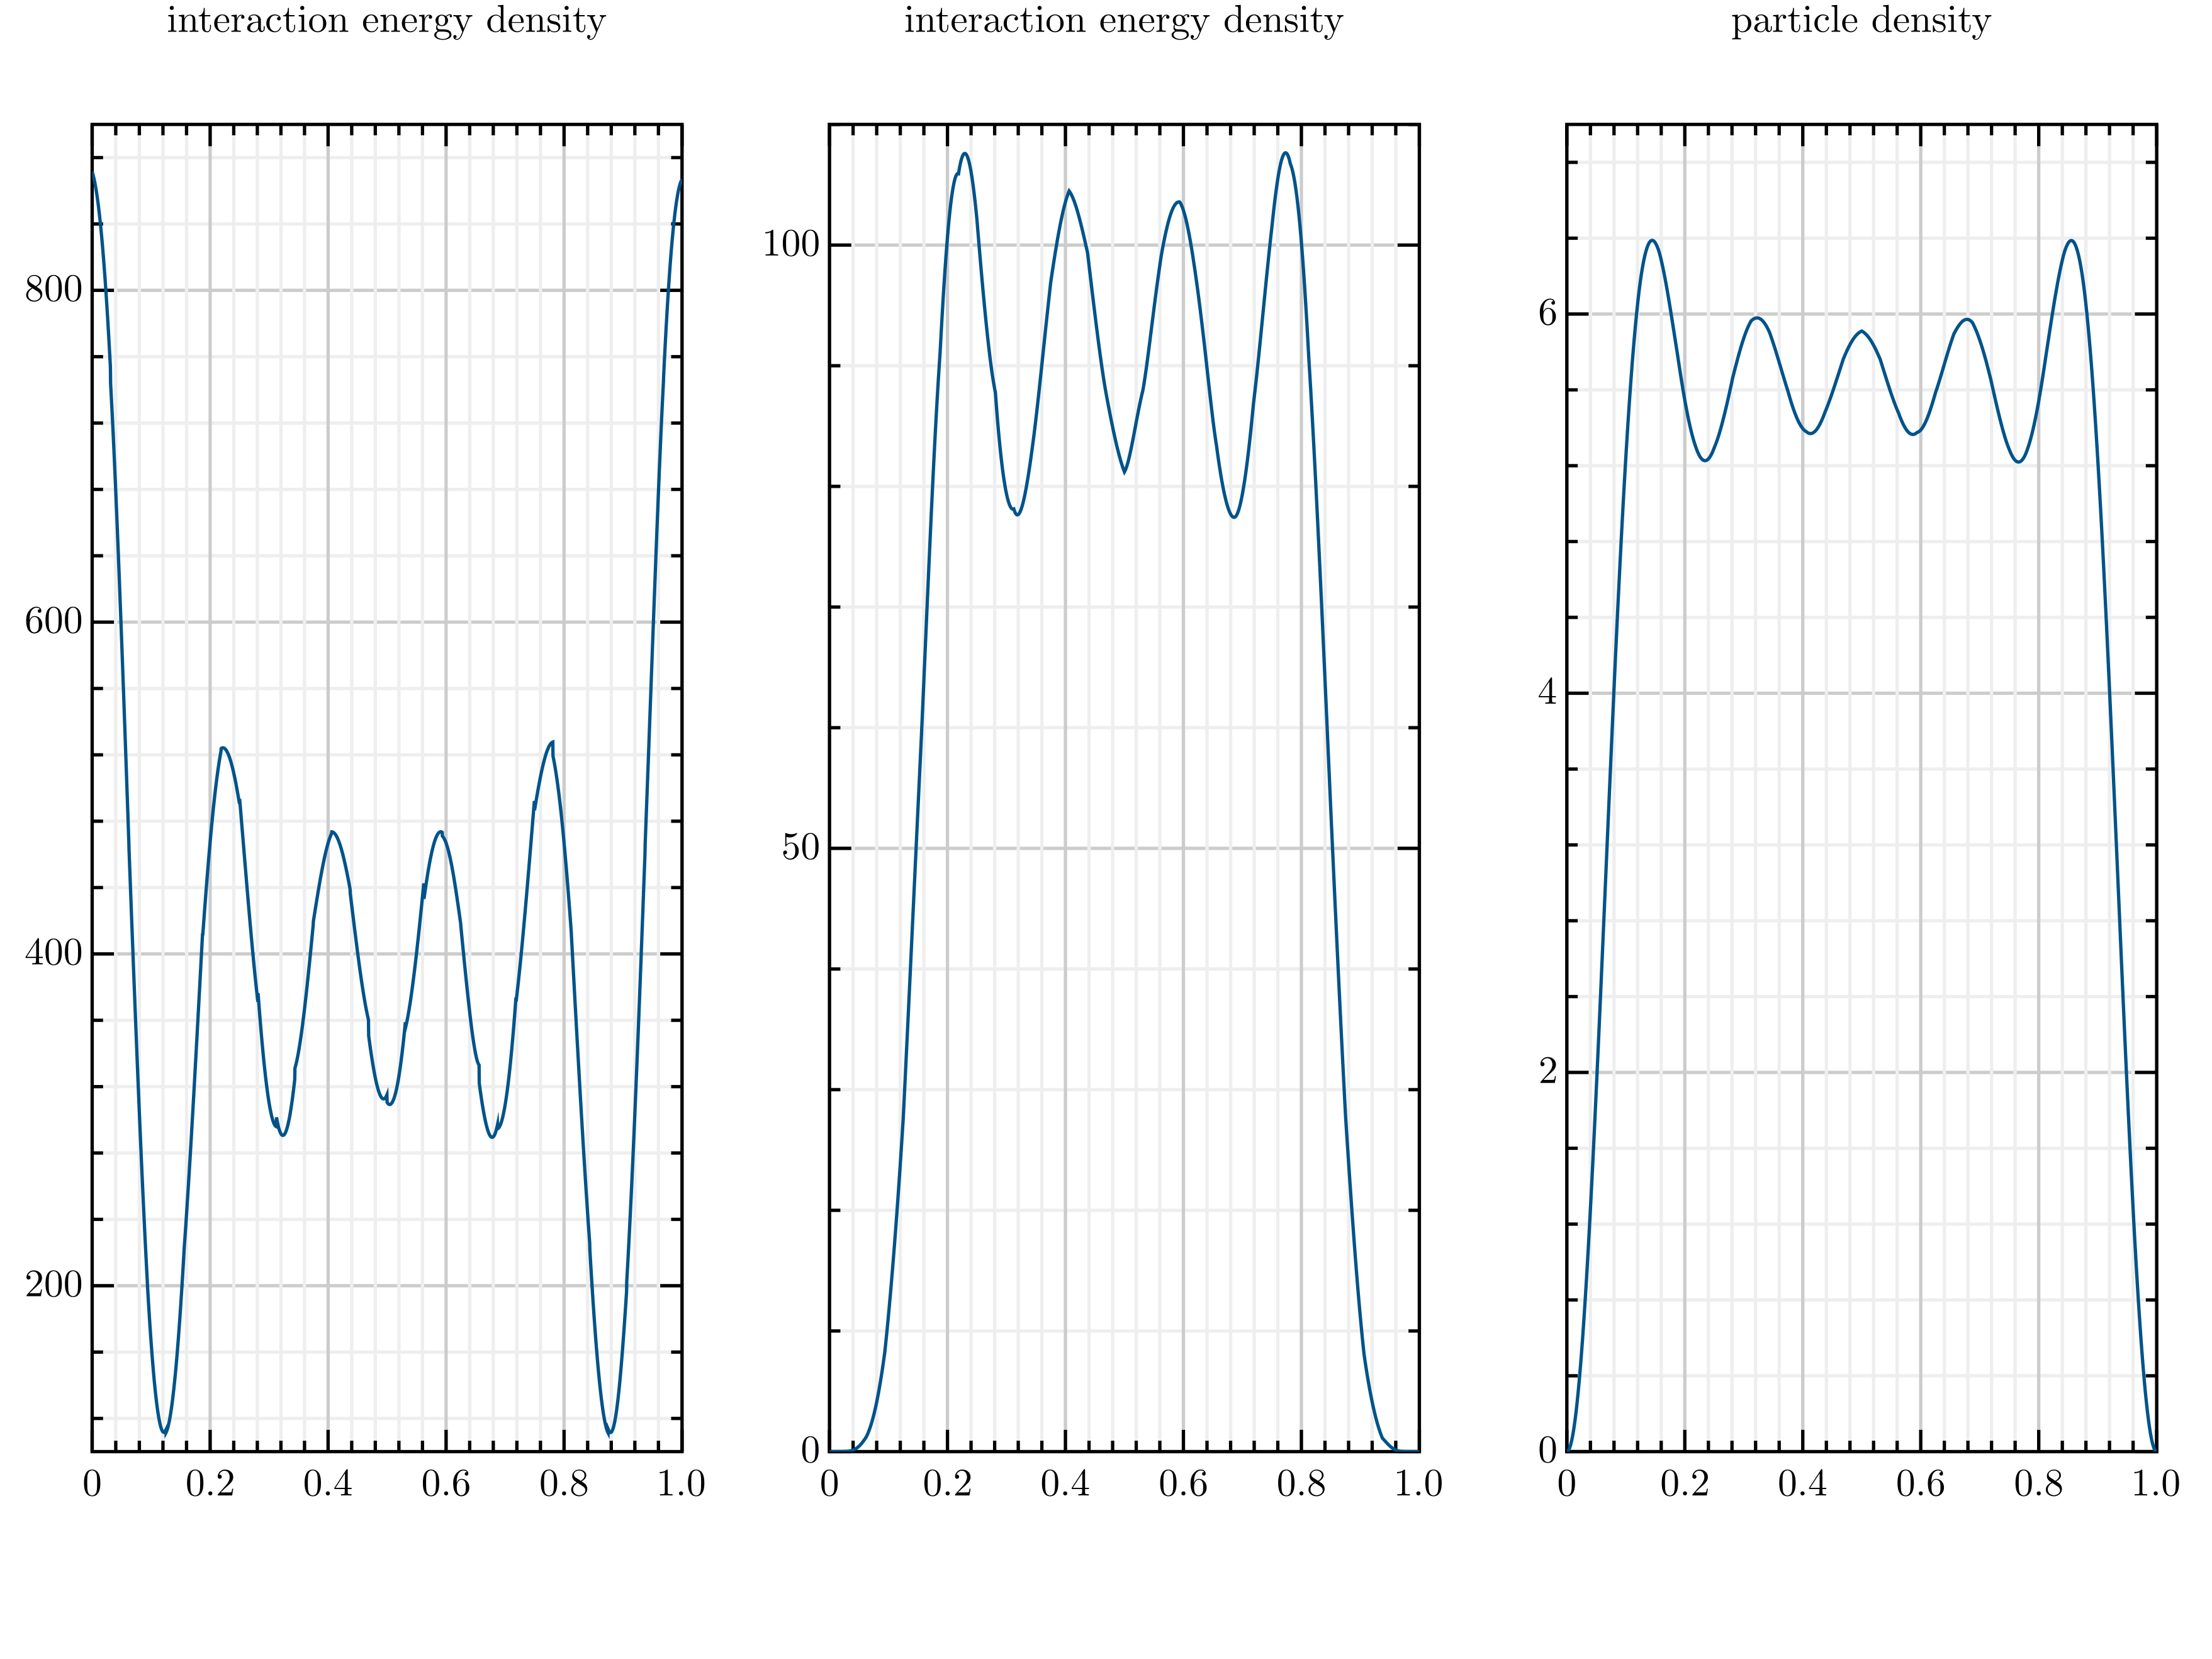

In [95]:
particle_density = expval(n̂, Φ)
kinetic_energy_density = expval(k̂, Φ)
interaction_energy_density = expval(100*û, Φ);# plot densities
plotgrid = 0:1/3200:1;
subplot(1,3,1)
plot(plotgrid, kinetic_energy_density.(plotgrid))
title("interaction energy density")
subplot(1,3,2)
plot(plotgrid, interaction_energy_density.(plotgrid))
# hold(true)
# plot(grid, zero(grid),"+")
title("interaction energy density")
# plot(plotgrid, kinetic_energy_density.(plotgrid), plotgrid, interaction_energy_density.(plotgrid))
# legend("kinetic energy density", "interaction energy density")
subplot(1,3,3)
plot(plotgrid, particle_density.(plotgrid))
title("particle density")

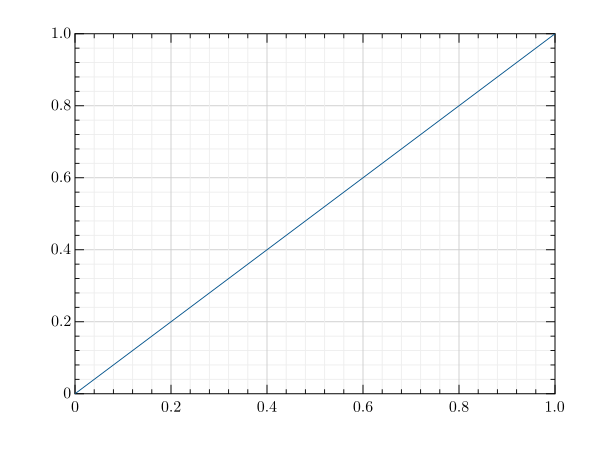

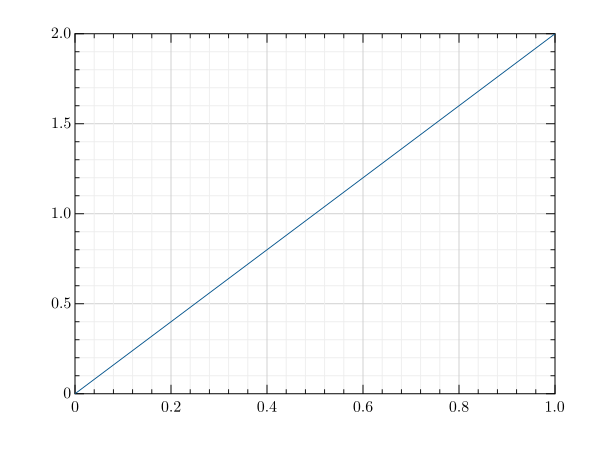

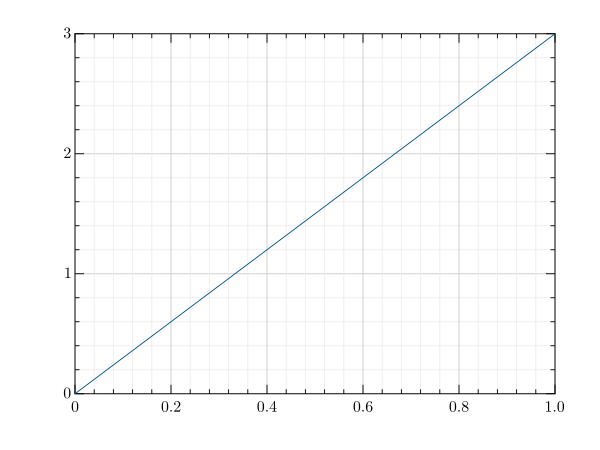

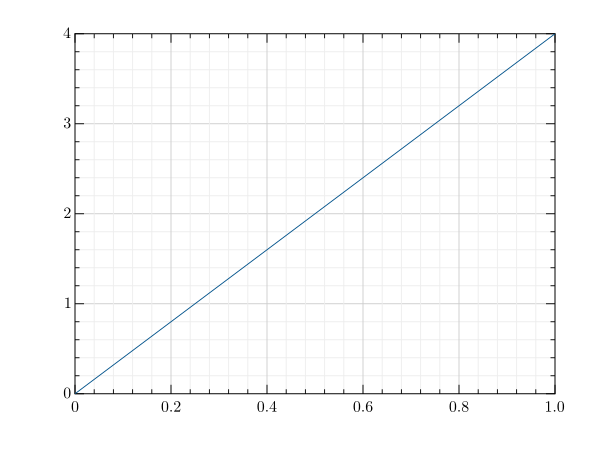

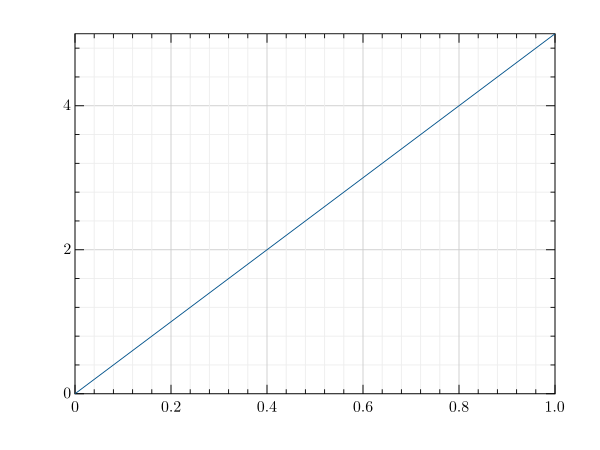

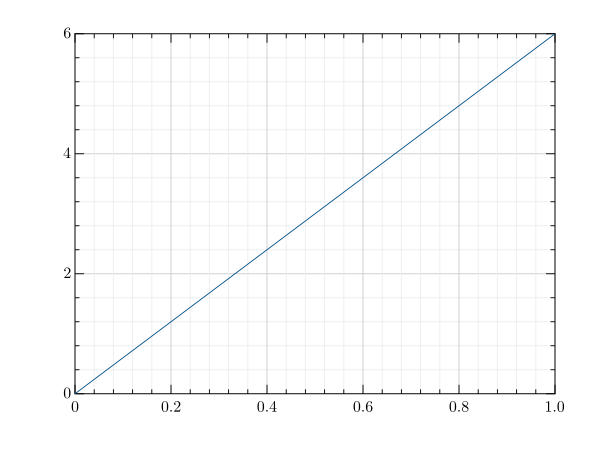

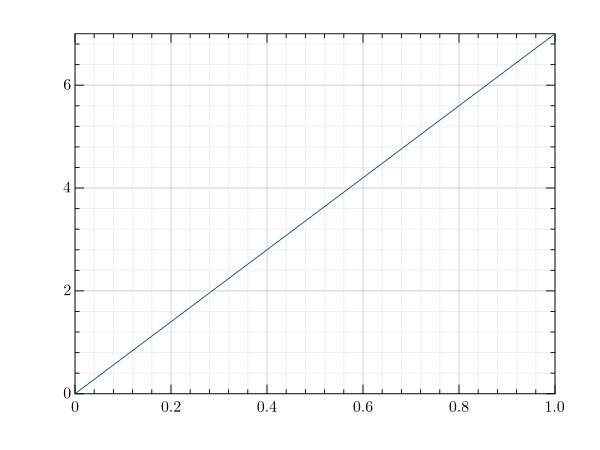

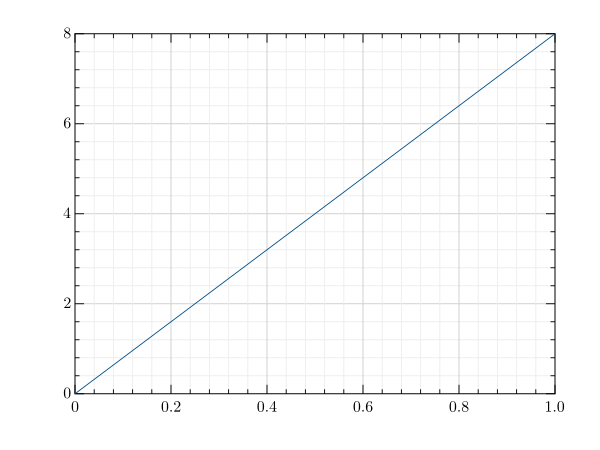

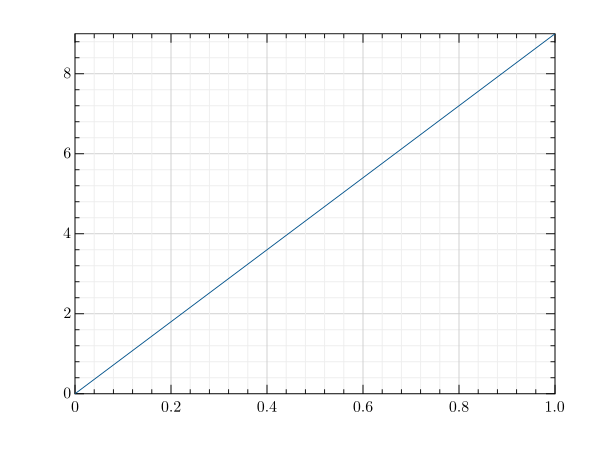

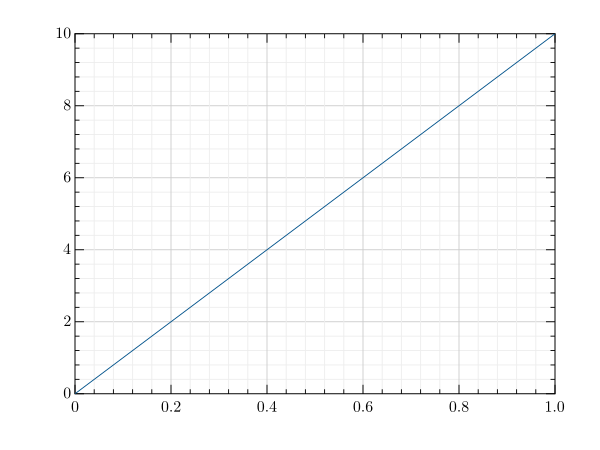

In [29]:
fig = Figure();
for n = 1:10
plot!(fig, 0:0.1:1, n*(0:0.1:1))
display(fig)
end

In [44]:
[∫(interaction_energy_density[i], (grid[i],grid[i+1])) for i = 1:length(grid)-1]

32-element Array{Float64,1}:
 0.13852715291773793
 0.1992793555846321
 0.19400985120953002
 0.19123070874707526
 0.14197405102655208
 0.1541937283235686
 0.1703069364367059
 0.31015194989646844
 0.5069939391939715
 0.5663482198341451
 0.3825322913733852
 0.37682661840626785
 0.4112637729347744
 ⋮
 0.22376516061331378
 0.3050170072474829
 0.25790475404733443
 0.19263672259597953
 0.14730103967548663
 0.15688211097860177
 0.1561524623915782
 0.11109000160637968
 0.13627380257125446
 0.15572682998249143
 0.1001347606142354
 0.04710302900291822

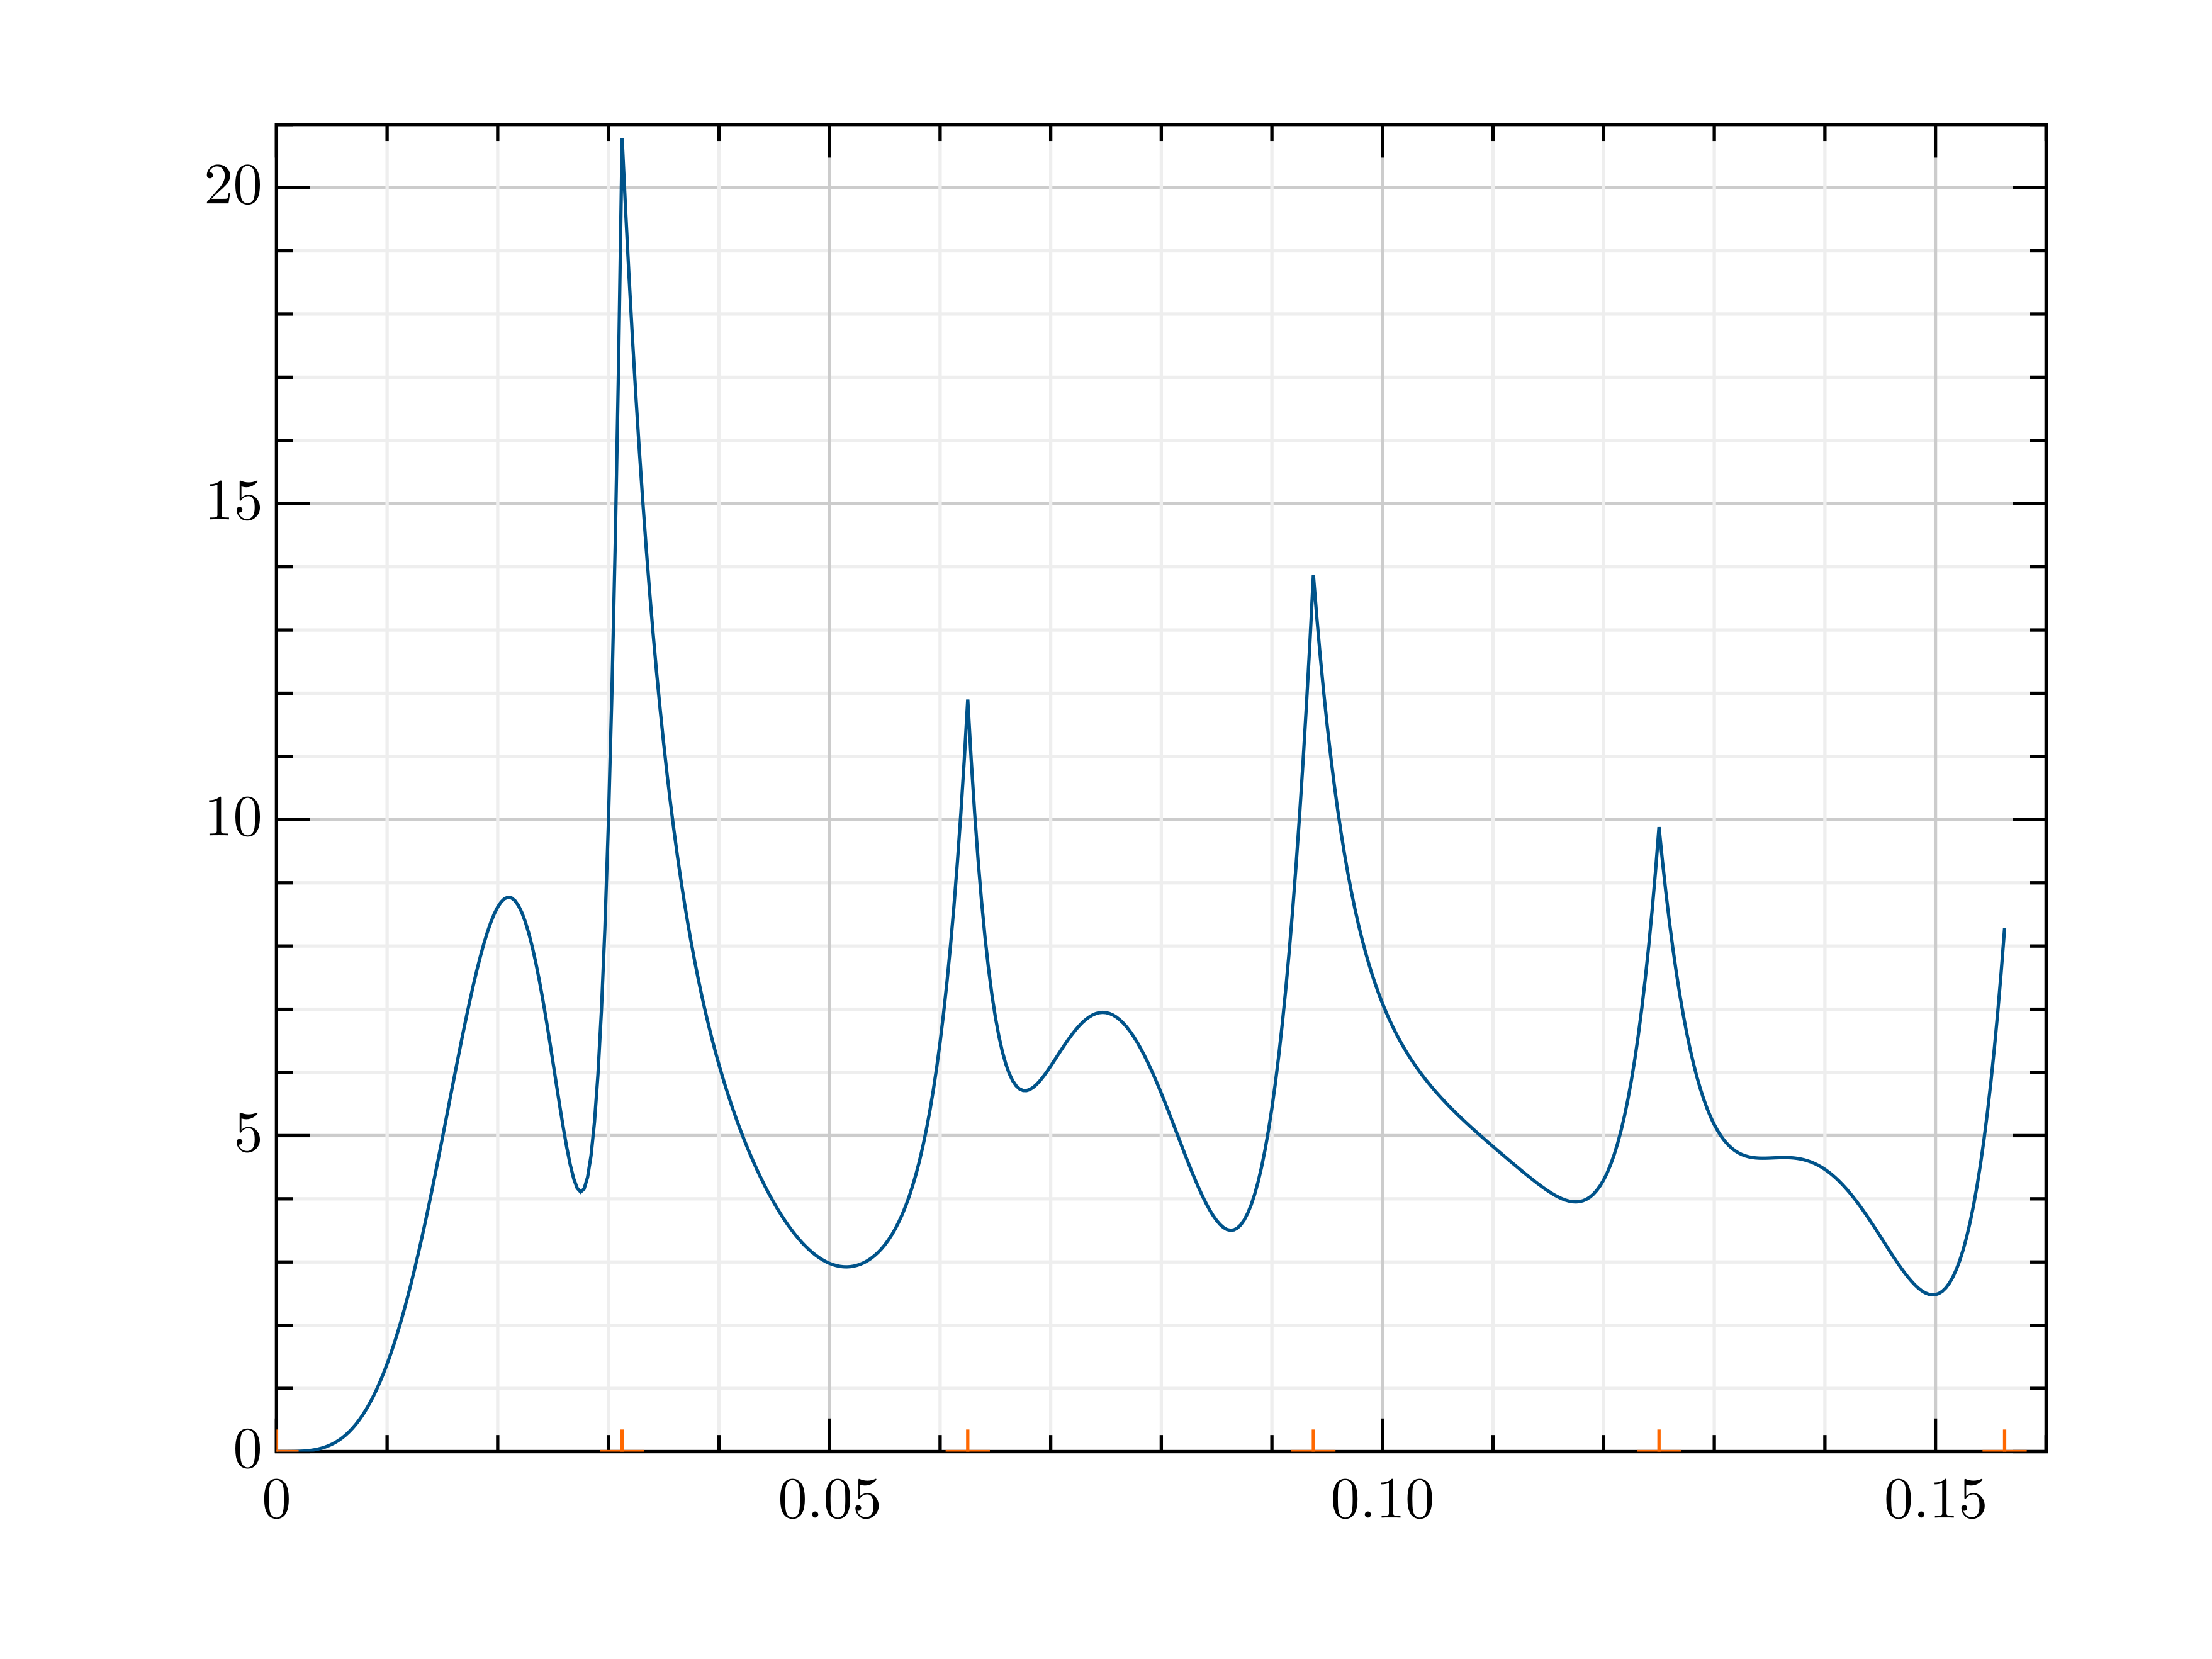

In [89]:
ρL, = leftenv(Φ);
ρR, = rightenv(Φ);
Figure()
plotgrid = 0:1/3200:grid[6]
R = Φ.Rs[1]
plot(plotgrid, interaction_energy_density.(plotgrid))
hold(true)
plot(grid[1:6], zero(grid[1:6]),"+")

In [78]:
[CMPSKit.offset.(getindex.((R,), 1:32)) CMPSKit.offset.(ρL.elements)]

32×2 Array{Float64,2}:
 0.015625  0.015625
 0.046875  0.046875
 0.078125  0.078125
 0.109375  0.109375
 0.140625  0.140625
 0.171875  0.171875
 0.203125  0.203125
 0.234375  0.234375
 0.265625  0.265625
 0.296875  0.296875
 0.328125  0.328125
 0.359375  0.359375
 0.390625  0.390625
 ⋮         
 0.640625  0.640625
 0.671875  0.671875
 0.703125  0.703125
 0.734375  0.734375
 0.765625  0.765625
 0.796875  0.796875
 0.828125  0.828125
 0.859375  0.859375
 0.890625  0.890625
 0.921875  0.921875
 0.953125  0.953125
 0.984375  0.984375

In [17]:
function plotresults(Ψ, ρL, ρR, e, E; plotgrid = 0:1e-4:1)
    ekin = expval(k̂, Ψ, ρL, ρR)
    density = expval(n̂, Ψ, ρL, ρR)
    interaction = expval(c*î, Ψ, ρL, ρR)
    #R² = R*R;
    #interaction = localdot(ρL, c*R²*ρR*R²');
    fig = Figure()
    subplot(1, 4, 1)
    plot(plotgrid, e.(plotgrid))
    legend("e")
    subplot(1, 4, 2) 
    plot(plotgrid, density.(plotgrid))
    legend("dens")
    subplot(1,4,3)
    plot(plotgrid, interaction.(plotgrid))
    legend("eint")
    subplot(1,4,4)
    plot(plotgrid, ekin.(plotgrid))
    legend("ekin")
    display(fig)
end;

function _kron(a,b)
    @tensor result[-1 -2;-3 -4] := a[-1 ;-3]*b[-2;-4]
    return reshape(result,(size(result,1)*size(result,2),size(result,3)*size(result,4)))
end;

function Rexact(x,N)
    Z = [1. 0.;0. -1.]
    one = [1. 0.;0. 1.]
    R = zeros(2^N,2^N)
    for k in 1:N
        Rk = [0. sqrt(2)*sin(k*pi*x);0. 0.]
        Zk = reshape([1.],(1,1))
        onek = reshape([1.],(1,1))
        for i in 1:k-1
            Zk = _kron(Zk,Z)
        end
        for i in 1:N-k
            onek = _kron(onek,one)
        end
        R += _kron(_kron(Zk,Rk),onek)
    end
    return R
end;

In [12]:
# Introducing the variables and hamiltonian of the system and choosing the algorithm
# The bond dimension:
D = 8;
# The random Finite cMPS:
T = Float64;
grid = 0:0.2:1;
Qlist = [randn(T, (D,D)) for _ in grid];
Rlist = [randn(T, (D,D)) for _ in grid];
Rlist[1] = zero(Rlist[1]);
Rlist[end] = zero(Rlist[end]);
Q = PiecewiseLinear(grid, Qlist);
R = PiecewiseLinear(grid, Rlist);
newgrid = 0:1/31:1;
Q = PiecewiseLinear(newgrid, Q.(newgrid));
R = PiecewiseLinear(newgrid, R.(newgrid));
vR = vL = setindex!(zeros(T, D), 1, 1);
Ψ = FiniteCMPS(Q, R, vL, vR);

alg = LBFGS(30; verbosity = 1, maxiter = 1000000, gradtol = 1e-1)

# The algorithm (ConjugateGradient, LBFGS,...):


In [25]:
@load "DataExactFiniteD8" Ψ ρL ρR E e normgrad numfg history;

In [26]:
E

-594.1124588553446

In [27]:
ρL(0)

8×8 Array{Float64,2}:
  1.0           3.46945e-18   3.81639e-17  …  -2.08167e-17   6.07153e-18
  3.46945e-18  -1.0842e-19    4.37747e-18     -2.81893e-18  -1.02999e-18
  3.81639e-17   4.37747e-18   3.20382e-17     -3.84892e-18  -1.29291e-17
 -6.93889e-18   5.42101e-19   8.91756e-18     -4.49944e-18   7.45389e-19
  2.21177e-17   1.03677e-18   1.35186e-17     -5.69206e-19  -9.41223e-18
  1.64799e-17   1.32815e-18  -3.07642e-18  …   6.74916e-18  -5.3668e-18
 -2.08167e-17  -2.81893e-18  -3.84892e-18     -5.42101e-18   7.20994e-18
  6.07153e-18  -1.02999e-18  -1.29291e-17      7.20994e-18  -3.91668e-18

In [13]:
# Optimising the finite cMPS:
optimisation = false;
if optimisation
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(H, Ψ, alg; 
        #optimnodes = 0:0.1:1, 
        #plot = plotresults
    );
else
    @load "DataExactFiniteD8" Ψ ρL ρR E e normgrad numfg history;
end;

In [14]:
# Extracting the Q and R matrices out of the optimised cMPS
Q = Ψ.Q;
R = (Ψ.Rs)[1];
# Separating the terms of the Hamiltonian 
n̂ = ψ'*ψ;
k̂ = ∂ψ'*∂ψ;
î = (ψ')^2*ψ^2;
N̂ = ∫(n̂, (0,1));

In [15]:
# Calculating some quantities
# The norm:
@show Z = CMPSKit.dot(ρL,ρR);
# The energy:
@show E = expval(H, Ψ, ρL, ρR);
# The density:
@show N = expval(N̂, Ψ, ρL, ρR);
# The variance of the density:
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;

Z = CMPSKit.dot(ρL, ρR) = 1.0000000000000002
E = expval(H, Ψ, ρL, ρR) = -594.1124588553445
N = expval(N̂, Ψ, ρL, ρR) = 3.9999073153252778
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 0.0002605297218458702


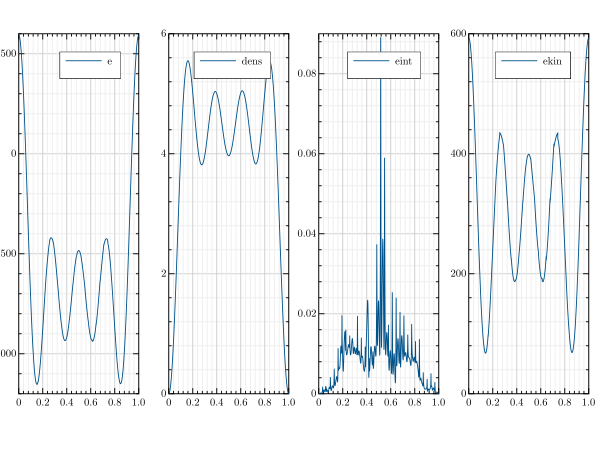

In [18]:
plotresults(Ψ, ρL, ρR, e, E; plotgrid = 0:1e-4:1)

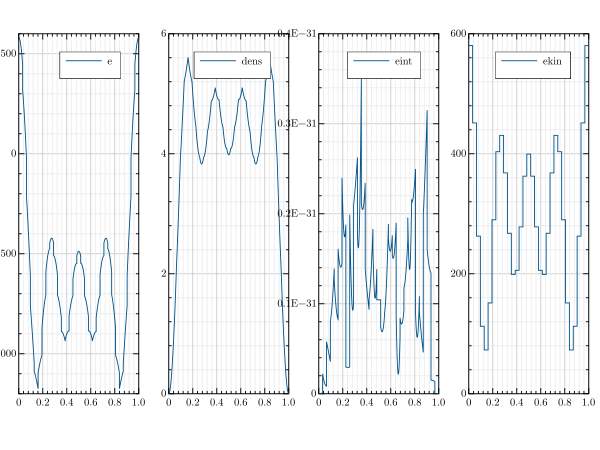

Z = CMPSKit.dot(ρL, ρR) = 0.9999999999999998
E = expval(H, Ψ, ρL, ρR) = -591.6395636074627
N = expval(N̂, Ψ, ρL, ρR) = 3.999999999999998
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 1.2434497875801753e-14
ΔN = sqrt((2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2) = 1.1151007970493857e-7


In [9]:
D = 16;

# The Hamiltonian (Lieb-Liniger):
μ = (4.75*pi)^2;
c = 1e6;
h = ∂ψ'*∂ψ - μ * ψ'*ψ + c * (ψ')^2*ψ^2
H = ∫(h, (0,1));
# Introducing the variables and hamiltonian of the system and choosing the algorithm
# The random Finite cMPS:
T = Float64;
grid = 0:1/31:1;
L = length(grid);
N = 4;
D = 2^N;

global Rlist = [zeros(D,D)]
for i in (1/31):(1/31):(1-1/31)
    #@show reshape(Rexact(i,N),(D^2,1))
    push!(Rlist, Rexact(i,N))
end
push!(Rlist,zeros(D,D))
Qlist = [zeros(D,D) for _ in grid];
Q = PiecewiseLinear(grid, Qlist);
R = PiecewiseLinear(grid, Rlist);
vL = setindex!(zeros(T, D), 1, 1);
vR = setindex!(zeros(T, D), 1, D);
Ψ = FiniteCMPS(Q, R, vL, vR);
ρL,ρR,_,_ = environments!(Ψ;Kmax = 200);
# Calculating some quantities
# The norm:
@show Z = CMPSKit.dot(ρL,ρR);
# The energy:
@show E = expval(H, Ψ, ρL, ρR);
e = expval(h, Ψ, ρL, ρR)
# The density:
@show N = expval(N̂, Ψ, ρL, ρR);
# The variance of the density:
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;
@show ΔN = sqrt(2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2);
plotresults(Ψ, ρL, ρR, e, E; plotgrid = 0:1e-4:1)

In [9]:
# Introducing the variables and hamiltonian of the system and choosing the algorithm
# The bond dimension:
D = 32;
# The random Finite cMPS:
T = Float64;
grid = 0:0.5:1;
Qlist = [randn(T, (D,D)) for _ in grid];
Rlist = [randn(T, (D,D)) for _ in grid];
Rlist[1] = zero(Rlist[1]);
Rlist[end] = zero(Rlist[end]);
Q = PiecewiseLinear(grid, Qlist);
R = PiecewiseLinear(grid, Rlist);
newgrid = 0:0.01:1;
Q = PiecewiseLinear(newgrid, Q.(newgrid));
R = PiecewiseLinear(newgrid, R.(newgrid));
vR = vL = setindex!(zeros(T, D), 1, 1);
Ψ = FiniteCMPS(Q, R, vL, vR);

# The algorithm (ConjugateGradient, LBFGS,...):
alg = LBFGS(30; verbosity = 2, maxiter = 1000000, gradtol = 1e-1)

# The Hamiltonian (Lieb-Liniger):    
μ = 1749;
function potential(x)
    return 1749*sin(15*pi*x)
end
V = Array{TaylorSeries{Float64,Float64}}(undef,length(newgrid)-1)
for i in 1:(length(newgrid)-1)
    xᵢ = newgrid[i]
    xⱼ = newgrid[i+1]
    V[i] = fit(potential,TaylorSeries,(xᵢ,xⱼ))
    CMPSKit.shift!(V[i], (xᵢ+xⱼ)/2)
end
V = CMPSKit.Piecewise(newgrid, V)
c = 35;

H = ∫(∂ψ'*∂ψ + V * ψ'*ψ - μ * ψ'*ψ + c * (ψ')^2*ψ^2, (0,1));

In [10]:
# Optimising the finite cMPS:
optimisation = false
if optimisation
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(H, Ψ, alg; 
        #optimnodes = 0:0.1:1, 
        #plot = plotresults
    );
else
    @load "DataSineFiniteD32" Ψ ρL ρR E e normgrad numfg history
end;


In [11]:
# Extracting the Q and R matrices out of the optimised cMPS
Q = Ψ.Q;
R = (Ψ.Rs)[1];
# Intoducing the density term of the Hamiltonian (used to calculate density and its variance)
n̂ = ψ'*ψ;
V̂ = V*ψ'*ψ;
k̂ = ∂ψ'*∂ψ;
î = (ψ')^2*ψ^2;
N̂ = ∫(n̂, (0,1));

In [12]:
# Calculating some quantities
# The norm:
@show Z = CMPSKit.dot(ρL,ρR);
# The energy:
@show E = expval(H, Ψ, ρL, ρR);
# The density:
@show N = expval(N̂, Ψ, ρL, ρR);
# The variance of the density:
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;
@show ΔN = sqrt(2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2);

Z = CMPSKit.dot(ρL, ρR) = 1.0000000000000009
E = expval(H, Ψ, ρL, ρR) = -39525.0252433687
N = expval(N̂, Ψ, ρL, ρR) = 33.000772644565735
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 0.005639996837544459
ΔN = sqrt((2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2) = 0.07509991236708907


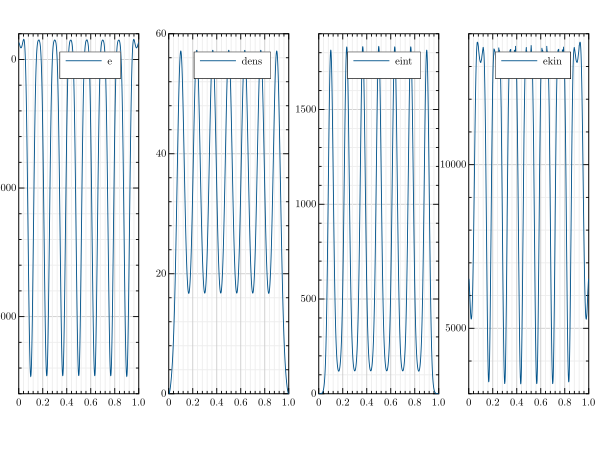

In [13]:
plotresults(Ψ, ρL, ρR, e, E; plotgrid = 0:1e-4:1)

In [23]:
# Introducing the variables and hamiltonian of the system and choosing the algorithm
# The bond dimension:
D = 32;
# The random uniform cMPS:
Q = Constant(randn(D,D)/D);
R = Constant(randn(D,D)/D);
Ψ = InfiniteCMPS(Q, R);

# The algorithm (ConjugateGradient, LBFGS,...):
alg = LBFGS(; verbosity = 1, maxiter = 10^6, gradtol = 1e-4);

# The Hamiltonian (Lieb-Liniger):
μ = 10000
c = 1000
h = ∂ψ'*∂ψ - μ * ψ'*ψ + c * (ψ')^2*ψ^2
H = ∫(h, (-Inf,+Inf));

In [24]:
# Optimising the uniform cMPS:
optimisation = false
if optimisation
    ΨL, ρR, E, e, normgrad, numfg, history = groundstate(H, Ψ; optalg = alg, linalg = GMRES(; tol = 1e-6));
else
    @load "DataSineUniformD32" ΨL ρR E e

end;

In [25]:
# Extracting the Q and R matrices out of the optimised cMPS
Q = Ψ.Q;
R = (Ψ.Rs)[1];
ρL = one(ρR);
# Intoducing the density term of the Hamiltonian (used to calculate density and its variance)
n̂ = ψ'*ψ;
N̂ = ∫(n̂, (-Inf,+Inf));

In [29]:
# Calculating some quantities
# The norm:
@show Z = CMPSKit.dot(ρL,ρR);
# The energy:
@show E = expval(h, Ψ, ρL, ρR)[];
# The density:
@show N = expval(n̂, Ψ, ρL, ρR)[];
# The variance of the density:
@show ΔN = sqrt(2*tr(leftenv(N̂, (ΨL,ρL,ρR))[1]*R*ρR*R')[] + N[]);

Z = CMPSKit.dot(ρL, ρR) = 1.0
E = (expval(h, Ψ, ρL, ρR))[] = -323.75366161608
N = (expval(n̂, Ψ, ρL, ρR))[] = 0.03246253639851392


LoadError: [91mUndefVarError: tr not defined[39m

In [18]:
# Now for the Finite cMPS
# Introducing the variables and hamiltonian of the system and choosing the algorithm
# The bond dimension:
D = 4;
# The random Finite cMPS:
T = Float64;
grid = 0:0.5:1;
Qlist = [randn(T, (D,D)) for _ in grid];
Rlist = [randn(T, (D,D)) for _ in grid];
Rlist[1] = zero(Rlist[1]);
Rlist[end] = zero(Rlist[end]);
Q = PiecewiseLinear(grid, Qlist);
R = PiecewiseLinear(grid, Rlist);
newgrid = 0:0.01:1;
Q = PiecewiseLinear(newgrid, Q.(newgrid));
R = PiecewiseLinear(newgrid, R.(newgrid));
vR = vL = setindex!(zeros(T, D), 1, 1);
Ψ = FiniteCMPS(Q, R, vL, vR);

alg = LBFGS(30; verbosity = 2, maxiter = 100000, gradtol = 1e-1)

D = 64
T = Float64;
N = 300
grid = range(0.,stop = 1.,length = N+1);
grid = (1 .- cos.(grid*pi)) ./ 2


# The algorithm (ConjugateGradient, LBFGS,...):
# The Hamiltonian (Lieb-Liniger):
μ = 10000;
c = 1000;
h = ∂ψ'*∂ψ - μ * ψ'*ψ + c * (ψ')^2*ψ^2
H = ∫(h, (0,1));

In [19]:
# Optimising the finite cMPS:
optimisation = false
if optimisation
    Ψ, ρL, ρR, E, e, normgrad, numfg, history =
        groundstate(H, Ψ, alg; 
        #optimnodes = 0:0.1:1, 
        #plot = plotresults
        );
else
    @load "Datamu10000c1000FiniteD64"  Ψ ρL ρR E
end

4-element Array{Symbol,1}:
 :Ψ
 :ρL
 :ρR
 :E

In [20]:
# Extracting the Q and R matrices out of the optimised cMPS
Q = Ψ.Q;
R = (Ψ.Rs)[1];
# Intoducing the density term of the Hamiltonian (used to calculate density and its variance)
n̂ = ψ'*ψ;
k̂ = ∂ψ'*∂ψ;
î = (ψ')^2*ψ^2;
N̂ = ∫(n̂, (0,1));

In [21]:
# Calculating some quantities
# The norm:
@show Z = CMPSKit.dot(ρL,ρR);
# The energy:
@show E = expval(H, Ψ, ρL, ρR);
e = expval(h, Ψ, ρL, ρR)
# The density:
@show N = expval(N̂, Ψ, ρL, ρR);
# The variance of the density:
@show ΔN² = 2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2;
@show ΔN = sqrt(2*integrate(localdot(leftenv(N̂, (Ψ,ρL,ρR))[1], R*ρR*R')) + N - N^2);

Z = CMPSKit.dot(ρL, ρR) = 0.9999999999999999
E = expval(H, Ψ, ρL, ρR) = -221056.08479199553
N = expval(N̂, Ψ, ρL, ρR) = 33.99992574212574
ΔN² = (2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2 = 0.0006754284788712539
ΔN = sqrt((2 * integrate(localdot((leftenv(N̂, (Ψ, ρL, ρR)))[1], R * ρR * R')) + N) - N ^ 2) = 0.025989006885051492


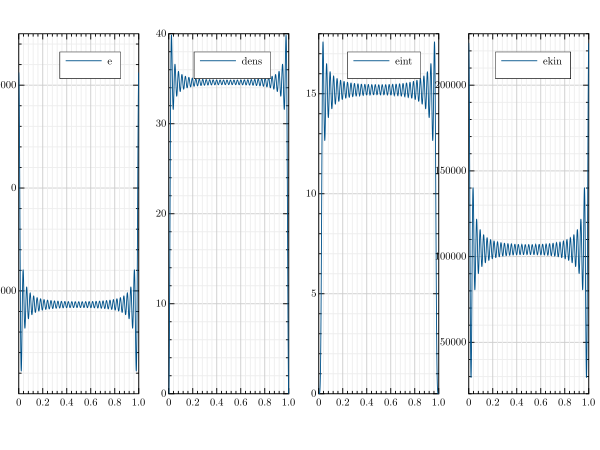

In [22]:
plotresults(Ψ, ρL, ρR, e, E; plotgrid = 0:1e-4:1)